In [ ]:
import zipfile, os


In [ ]:
!pwd


/content/drive/My Drive/gambarr


In [ ]:
cd /content/drive/MyDrive/gambarr/

/content/drive/MyDrive/gambarr


In [ ]:
ls


 3/      d/         foto.zip     my_model.h5
 3.zip   data/      gambar/     'WhatsApp Image 2021-04-01 at 21.40.20.jpeg'
 a/      data.zip   gambar.zip  'WhatsApp Image 2021-08-20 at 17.22.12.jpeg'
 c/      foto/      k/


In [ ]:
local_zip = '/content/drive/My Drive/gambarr/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
print("Jumlah Data Train Tiap Kelas")
print('Jumlah gambar buah    :', len(os.listdir('data/orang/')))
print('Jumlah gambar buah    :', len(os.listdir('data/kucing/')))



Jumlah Data Train Tiap Kelas
Jumlah gambar buah    : 986
Jumlah gambar buah    : 885


In [ ]:
 
os.mkdir('/content/drive/MyDrive/gambarr/d/')
os.mkdir('/content/drive/MyDrive/gambarr/d/train/')
os.mkdir('/content/drive/MyDrive/gambarr/d/val/')
os.mkdir('/content/drive/MyDrive/gambarr/d/train/orang')
os.mkdir('/content/drive/MyDrive/gambarr/d/val/orang')
os.mkdir('/content/drive/MyDrive/gambarr/d/train/kucing')
os.mkdir('/content/drive/MyDrive/gambarr/d/val/kucing')


 


In [ ]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

train_ratio = 0.8

#Pembagian Training dan Validasi

source_00 = 'data/kucing/'
train_00 = 'd/train/kucing/'
val_00 = 'd/val/kucing/'
train_val_split(source_00, train_00, val_00, train_ratio)


source_01 = 'data/orang/'
train_01 = 'd/train/orang/'
val_01 = 'd/val/orang/'
train_val_split(source_01, train_01, val_01, train_ratio)



In [ ]:
print('Jumlah All kucing     :', len(os.listdir('data/orang')))
print('Jumlah Train kucing   :', len(os.listdir('d/train/orang')))
print('Jumlah Val kucing     :', len(os.listdir('d/val/orang')))



Jumlah All kucing     : 986
Jumlah Train kucing   : 788
Jumlah Val kucing     : 198


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
                  rescale = 1./255.,
                  rotation_range = 30,
                  horizontal_flip = True,
                  shear_range = 0.3,
                  fill_mode = 'nearest',
                  width_shift_range = 0.2,
                  height_shift_range = 0.2,
                  zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
                rescale = 1./255.,
                rotation_range = 30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

In [ ]:
train_dir = 'd/train/'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 3,
    class_mode = 'categorical'
)

val_dir = 'd/val/'
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 3,
    class_mode = 'categorical'
)

Found 1496 images belonging to 2 classes.
Found 375 images belonging to 2 classes.


In [ ]:
# callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(200, activation = 'relu'),
          tf.keras.layers.Dropout(0.3,seed=112),
          tf.keras.layers.Dense(500, activation = 'relu'),
          tf.keras.layers.Dropout(0.5,seed=112),
          tf.keras.layers.Dense(2, activation = 'softmax')
          ])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9248)             

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
            train_generator,
            steps_per_epoch =20,
            epochs = 250,
            validation_data = val_generator,
            validation_steps = 5,
            verbose = 1,
            callbacks = [callbacks]
)

Epoch 1/250
20/20 [==============================] - 4s 172ms/step - loss: 0.7883 - accuracy: 0.4833 - val_loss: 0.7621 - val_accuracy: 0.4667
Epoch 2/250
20/20 [==============================] - 3s 161ms/step - loss: 0.7235 - accuracy: 0.4833 - val_loss: 0.6958 - val_accuracy: 0.4667
Epoch 3/250
20/20 [==============================] - 3s 160ms/step - loss: 0.7187 - accuracy: 0.5500 - val_loss: 0.6799 - val_accuracy: 0.7333
Epoch 4/250
20/20 [==============================] - 3s 161ms/step - loss: 0.7045 - accuracy: 0.5000 - val_loss: 0.7266 - val_accuracy: 0.3333
Epoch 5/250
20/20 [==============================] - 3s 160ms/step - loss: 0.7061 - accuracy: 0.5833 - val_loss: 0.6855 - val_accuracy: 0.6667
Epoch 6/250
20/20 [==============================] - 3s 159ms/step - loss: 0.6865 - accuracy: 0.6333 - val_loss: 0.6712 - val_accuracy: 0.5333
Epoch 7/250
20/20 [==============================] - 3s 162ms/step - loss: 0.6992 - accuracy: 0.6833 - val_loss: 0.7003 - val_accuracy: 0.4667

In [ ]:
model.save('my_model.h5')

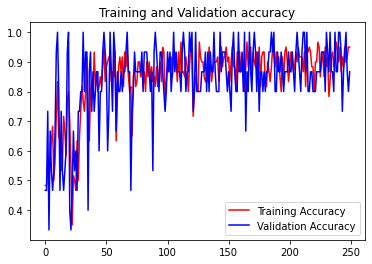

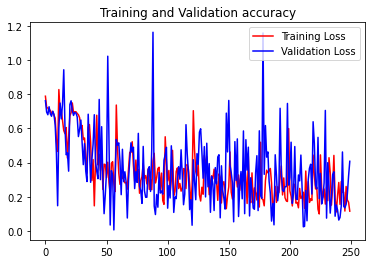

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

Saving WhatsApp Image 2021-04-01 at 21.40.20.jpeg to WhatsApp Image 2021-04-01 at 21.40.20 (1).jpeg
WhatsApp Image 2021-04-01 at 21.40.20.jpeg
This image belongs to class orang


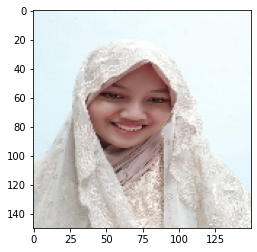

In [ ]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir('data/')
  
  for j in range(42):
    if classes[0][j] == 1. :
      print('This image belongs to class', class_list[j])
      break